# Stellar Structure Caclculation
This notebook calculates the ZAMS structure of a Sun-like star.

In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from scipy.optimize import root
import time

# Define constants in CGS units
k     = 1.3807e-16       # Boltzmann constant (erg/K)
m_H   = 1.673e-24        # Mass of hydrogen atom (g)
a     = 7.56577e-15      # Radiation density constant (erg cm^-3 K^-4)
G     = 6.67430e-8       # Gravitational constant (cm^3 g^-1 s^-2)
sigma = 5.670374419e-5   # Stefan-Boltzmann constant (erg cm^-2 s^-1 K^-4)
c     = 2.998e10         # Speed of light (cm/s)
NA    = 6.022e23         # Avogadro's number

#### Choose values for the star's mass, hydrogen mass fraction, helium mass fraction, and metal mass fraction. Here, I use solar values.

In [4]:
M_sol = 1.988e33
R_sol = 6.957e10
L_sol = 3.828e33

X = 0.7121  # Hydrogen mass fraction
Y = 0.2766  # Helium mass fraction
Z = 1 - (X + Y)  # Metallicity

#### Calculate density given pressure, temperature and composition, assuming complete ionization. Include the effect of radiation pressure.

In [6]:
def calc_mean_mol_weight(X):
    """
    Calculate the mean molecular weight assuming full ionization.
    
    Parameters:
        X : float
            Hydrogen mass fraction
    
    Returns:
        float : mean molecular weight (dimensionless)
    """
    return 4 / (3 + 5 * X) 

def calc_beta(rho, T, X, Y=0, Z=0):
    """
    Calculate the ratio of gas pressure to total pressure: beta = P_gas / (P_gas + P_rad)

    Parameters:
        rho : float
            Density (g/cm^3)
        T : float
            Temperature (K)
        X : float
            Hydrogen mass fraction

    Returns:
        float : beta
    """
    mu = calc_mean_mol_weight(X)
    P_gas = (rho * k * T) / (mu * m_H)
    P_rad = (1/3) * a * T**4
    return P_gas / (P_gas + P_rad)

def calc_rho(P, T, X=0.70, Y=0.28, Z=0.02):
    """
    Calculate density from pressure and temperature using the equation of state
    (including both gas and radiation pressure)
    
    Parameters:
        P : float
            Pressure (dyn/cm^2)
        T : float
            Temperature (K)
        X : float
            Hydrogen mass fraction
    
    Returns:
        float : density (g/cm^3)
    """
    mu = calc_mean_mol_weight(X)
    return (P - (1/3)*a*T**4) * (mu * m_H) / (k * T)

# Calculate mu for our star (X = 0.7)
mu = calc_mean_mol_weight(X)

In [7]:
# Test case:

rho_plasma_1 = calc_rho(P=10**16.85, T=10**7.55, X=0, Y=0.98, Z= 0.02)
rho_plasma_2 = calc_rho(P=10**16.87, T=10**6.91, X=0.70, Y=0.28, Z= 0.02)

beta_plasma_1 = calc_beta(rho=rho_plasma_1, T=10**7.55, X=0, Y=0.98, Z= 0.02)
beta_plasma_2 = calc_beta(rho=rho_plasma_2, T=10**6.91, X=0.70, Y=0.28, Z= 0.02)

print('1: \nrho: {} g/cm-3 \nbeta: {} \n'.format(rho_plasma_1, beta_plasma_1))
print('2: \nrho: {} g/cm-3 \nbeta: {}'.format(rho_plasma_2, beta_plasma_2))

1: 
rho: 30.415587322461395 g/cm-3 
beta: 0.9435411692381797 

2: 
rho: 67.99527780145085 g/cm-3 
beta: 0.9998514981445873


#### Obtain the appropriate opacity table for the selected composition from the Opacity Project website.

In [9]:
# Load opacity table

opacity_df = pd.read_csv("opacities.txt", sep='\s+')
colnames = ['logT', -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5,-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0]

logT_vals = opacity_df.iloc[:, 0].values  # First column (log10 T)
logR_vals = np.array([float(col) for col in opacity_df.columns[1:]])  # Column headers (log10 R)

# Extract opacity values (log10 κ)
logk_vals = opacity_df.iloc[:, 1:].values  # 2D array of log10 κ values

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/nz/df1z6w515yngdhnm_4p36qkc0005yb/T/ipykernel_71668/3359569711.py:3: SyntaxWarning: invalid escape sequence '\s'
  opacity_df = pd.read_csv("opacities.txt", sep='\s+')


#### Interpolate the opacity table for specific values of density and temperature in log density and log temperature space.

In [11]:
# Define interpolator

opacity_interp = RegularGridInterpolator(
    (logT_vals, logR_vals),  # Grid axes: log10(T), log10(R)
    logk_vals                # Grid values: log10(κ)
)

def get_opacity(T, rho):
    """
    Interpolate opacity from Opacity Project tables.
    Converts physical (T, ρ) to table coordinates (logT, logR), 
    where R = ρ / (T / 1e6)^3.

    Parameters:
        T : float
            Temperature (K)
        rho : float
            Density (g/cm^3)

    Returns:
        float : opacity κ (cm^2/g)
    """
    # Convert to logR parameter
    R_param = rho / (T / 1e6)**3

    # Apply lower bounds to avoid extrapolation errors
    R_param = max(R_param, 1e-8)
    T = max(T, 10**3.75)

    log_T = np.log10(T)
    log_R = np.log10(R_param)

    point = np.array([[log_T, log_R]])
    log_kappa = opacity_interp(point)[0]

    return 10 ** log_kappa  # Return κ in linear space


#### Calculate the rate of energy generation from hydrogen fusion given density, temperature, and composition, accounting for both the pp-chains and CNO cycles assuming the reactions have reached equilibrium. Also account for weak screening effects.

In [13]:
def weak_screening_factor(rho, T, Z1=1, Z2=1):
    """
    Compute the weak screening factor f11.
    
    Parameters:
        rho : float
            Density in g/cm^3
        T : float
            Temperature K
        Z1, Z2 : int
            Nuclear charges of reacting particles (default: hydrogen-hydrogen)
    
    Returns:
        float : f11
    """
    U0 = 0.188 * Z1 * Z2 * np.sqrt(Z1 + Z2) * (rho / (T/1e6)**3)**0.5
    return np.exp(U0 / ((T/1e6) * 1e6 * 8.617333262e-5))  # Convert kT to eV

def epsilon_pp(rho, T, X=X):
    """
    Compute the nuclear energy generation rate for the pp chain with weak screening.
    
    Parameters:
        rho : float
            Density in g/cm^3
        T : float
            Temperature K
        X : float
            Hydrogen mass fraction
    
    Returns:
        float : Energy generation rate in erg g^-1 s^-1
    """
    f11 = weak_screening_factor(rho, T)
    return f11 * (2.4e4 * rho * X**2 / (T/1e9)**(2/3)) * np.exp(-3.380 / (T/1e9)**(1/3))

def epsilon_CNO(rho, T, X=X, Z=Z):
    """
    Compute the nuclear energy generation rate for the CNO cycle with weak screening.
    
    Parameters:
        rho : float
            Density in g/cm^3
        T : float
            Temperature in K
        X : float
            Hydrogen mass fraction
        Z : float
            Metallicity (CNO catalyst abundance)
    
    Returns:
        float : Energy generation rate in erg g^-1 s^-1
    """
    f11 = weak_screening_factor(rho, T, Z1=1, Z2=6)  # Assuming CNO uses carbon (Z=6)
    return f11 * (4.4e25 * rho * X * Z / (T/1e9)**(2/3)) * np.exp(-15.228 / (T/1e9)**(1/3))

def epsilon_total(rho, T, X=X, Z=Z):
    """
    Compute the total nuclear energy generation rate of the pp chain and CNO cycle with weak screening.
    
    Parameters:
        rho : float
            Density in g/cm^3
        T : float
            Temperature in K
        X : float
            Hydrogen mass fraction
        Z : float
            Metallicity
    
    Returns:
        float : Energy generation rate in erg g^-1 s^-1
    """
    
    return epsilon_pp(rho, T, X) + epsilon_CNO(rho, T, X, Z)

#### Write load1 and load2, functions to define the interior/exterior starting points of the shootf function.
Goal: Obtain a converged solution to the fourth order differnetial equation of stellar structure.

In [15]:
def load1(m_core, P_c, T_c, diagnostic=False):
    """
    Inner boundary condition near the center of the star.
    
    Parameters:
        m_core : float
            Small mass shell near center to avoid singularity (g)
        P_c : float
            Central pressure (dyn/cm²)
        T_c : float
            Central temperature (K)
        diagnostic : bool
            If True, prints whether the core is radiative or convective
    
    Returns:
        tuple : (radius, luminosity, pressure, temperature)
    """
    # Compute central density ρ_c from the EOS
    rho_c = calc_rho(P_c, T_c)

    # Estimate radius from uniform density sphere formula
    r_core = (3 * m_core / (4 * np.pi * rho_c))**(1/3)

    # Total energy generation rate per gram (pp + CNO)
    epsilon_c = epsilon_total(rho_c, T_c)

    # Initial luminosity from energy generation in central shell
    L_core = epsilon_c * m_core

    # Estimate pressure gradient correction from hydrostatic equilibrium
    prefactor = (4 * np.pi / 3 * rho_c)**(4/3)
    delta_P = (3 * G / (8 * np.pi)) * prefactor * m_core**(2/3)
    P_core = P_c - delta_P

    # Opacity at center
    kappa_c = get_opacity(T_c, rho_c)

    # Compute temperature gradient
    del_rad = calc_del_rad(L_core, P_c, T_c, m_core)
    del_ad  = calc_del_conv(P_c, T_c)

    # Diagnostic
    if diagnostic:
        regime = "Radiative" if del_ad > del_rad else "Convective"
        print(f"[load1 diagnostic] Core regime: {regime}")
        print(f"  del_rad = {del_rad:.4e}")
        print(f"  del_ad  = {del_ad:.4e}")
        print(f"  rho_c   = {rho_c:.4e} g/cm³")
        print(f"  L_core  = {L_core:.4e} erg/s")
        print(f"  r_core  = {r_core:.4e} cm")

    # Determine whether core is radiative or convective and calculate T_core accordingly
    if del_ad > del_rad:
        # Radiative core: use diffusion approximation
        temp_term = (T_c**4 
                     - (1 / (2 * a * c)) 
                     * (3 / (4 * np.pi))**(2/3)
                     * kappa_c * epsilon_c * rho_c**(4/3) * m_core**(2/3))
        T_core = temp_term**(1/4)
    else:
        # Convective core: use approximate exponential structure
        factor = (np.pi / 6)**(1/3)
        delta_T = np.exp(-factor * G * del_ad * rho_c**(4/3) / P_c * m_core**(2/3))
        T_core = T_c + delta_T

    return (r_core, L_core, P_core, T_core)


def load2(R_star, L_star):
    """
    Outer boundary condition near the stellar surface.
    
    Parameters:
        R_star : float
            Stellar radius (cm)
        L_star : float
            Stellar luminosity (erg/s)
    
    Returns:
        tuple : (radius, luminosity, pressure, temperature)
    """
    # Optical depth of the photosphere (Eddington approximation)
    tau_phot = 2 / 3

    # Effective surface temperature via Stefan-Boltzmann law
    T_eff = (L_star / (4 * np.pi * R_star**2 * sigma))**(1/4)

    # Temperature profile at depth τ using the Eddington approximation
    def T_tau(tau):
        return T_eff * (3/4 * (tau + 2/3))**(1/4)

    T_surface = T_tau(tau_phot)

    # Integrate dP/dτ = g / κ to compute pressure at τ = 2/3
    def dP_dtau(tau, P_arr):
        T_tau_val = T_tau(tau)
        rho_tau = calc_rho(P_arr[0], T_tau_val)
        g_surface = G * M_sol / R_star**2
        kappa_tau = get_opacity(T_tau_val, rho_tau)
        return [g_surface / kappa_tau]

    def P_tau(tau):
        sol = solve_ivp(dP_dtau, [0, tau], [0])
        return sol.y[0][-1]

    P_surface = P_tau(tau_phot)

    return (R_star, L_star, P_surface, T_surface)

In [16]:
def calc_del_rad(L_shell, P_shell, T_shell, m_shell):
    """
    Calculate the radiative temperature gradient at a given shell.
    
    Parameters:
        L_shell : float
            Luminosity at the shell (erg/s)
        P_shell : float
            Pressure at the shell (dyn/cm²)
        T_shell : float
            Temperature at the shell (K)
        m_shell : float
            Enclosed mass at the shell (g)
    
    Returns:
        float : del_rad (dimensionless temperature gradient)
    """
    rho_shell = calc_rho(P_shell, T_shell)
    kappa = get_opacity(T_shell, rho_shell)

    numerator = 3 * P_shell * kappa * L_shell
    denominator = 16 * np.pi * a * c * T_shell**4 * G * m_shell

    del_rad = numerator / denominator
    return del_rad

def calc_del_conv(P_shell, T_shell):
    """
    Calculate the adiabatic temperature gradient.
    
    Parameters:
        P_shell : float
            Pressure at the shell (dyn/cm²)
        T_shell : float
            Temperature at the shell (K)
    
    Returns:
        float : del_ad (dimensionless adiabatic gradient)
    """
    rho_shell = calc_rho(P_shell, T_shell)

    # β = ratio of gas pressure to total pressure
    beta = (rho_shell * NA * k * T_shell) / (mu * P_shell)

    # Approximate adiabatic gradient for ideal gas + radiation pressure
    del_ad = (8 - 6 * beta) / (32 - 24 * beta - 3 * beta**2)
    return del_ad


def calc_del_actual(L_shell, P_shell, T_shell, m_shell):
    """
    Compute the actual temperature gradient by comparing radiative and
    adiabatic gradients. Returns the smaller one.
    
    Parameters:
        L_shell : float
            Luminosity at the shell (erg/s)
        P_shell : float
            Pressure at the shell (dyn/cm²)
        T_shell : float
            Temperature at the shell (K)
        m_shell : float
            Enclosed mass at the shell (g)
    
    Returns:
        float : del (dominant temperature gradient, dimensionless)
    """
    del_ad  = calc_del_conv(P_shell, T_shell)
    del_rad = calc_del_rad(L_shell, P_shell, T_shell, m_shell)

    # Use radiative gradient if it's shallower (stable against convection)
    if del_ad > del_rad:
        return del_rad
    else:
        return del_ad


def derivs(m_shell, y_vec):
    """
    Compute the derivatives dl/dm, dP/dm, dr/dm, dT/dm for a given shell mass m.

    Parameters:
        m_shell : float
            Mass coordinate (g), the independent variable.
        y_vec : list or array of 4 floats
            The dependent variables at m_shell:
                y_vec[0] = r     (radius in cm)
                y_vec[1] = L     (luminosity in erg/s)
                y_vec[2] = P     (pressure in dyn/cm^2)
                y_vec[3] = T     (temperature in K)
    
    Returns:
        tuple : (dr/dm, dL/dm, dP/dm, dT/dm)
    """

    r = y_vec[0]  # radius
    L = y_vec[1]  # luminosity
    P = y_vec[2]  # pressure
    T = y_vec[3]  # temperature

    # Compute local density using EOS
    rho = calc_rho(P, T)

    # Compute energy generation rate (erg/g/s)
    epsilon = epsilon_total(rho, T)

    # Compute temperature gradient (either radiative or adiabatic)
    del_actual = calc_del_actual(L, P, T, m_shell)

    # Equations
    dr_dm = 1 / (4 * np.pi * r**2 * rho)
    dL_dm = epsilon
    dP_dm = -G * m_shell / (4 * np.pi * r**4)
    dT_dm = -G * m_shell * T / (4 * np.pi * r**4 * P) * del_actual

    return (dr_dm, dL_dm, dP_dm, dT_dm)

In [17]:
# Test input values
m_core_test = 1e-10 * M_sol       # Small mass near center
P_c_test = 2.65e17                # Central pressure (dyn/cm²)
T_c_test = 1.5e7                  # Central temperature (K)
R_star_test = R_sol               # Stellar radius (cm)
L_star_test = L_sol               # Stellar luminosity (erg/s)

# Load boundary values using test inputs
r_inner, L_inner, P_inner, T_inner = load1(m_core_test, P_c_test, T_c_test, diagnostic=False)
r_outer, L_outer, P_outer, T_outer = load2(R_star_test, L_star_test)

# Evaluate derivatives at inner boundary
print("\n[derivs] Inner derivatives:")
d_inner = derivs(m_core_test, [r_inner, L_inner, P_inner, T_inner])
print("  dr/dm = {:.3e}, dL/dm = {:.3e}, dP/dm = {:.3e}, dT/dm = {:.3e}".format(*d_inner))

# Evaluate derivatives at outer boundary
print("\n[derivs] Outer derivatives:")
d_outer = derivs(M_sol, [r_outer, L_outer, P_outer, T_outer])
print("  dr/dm = {:.3e}, dL/dm = {:.3e}, dP/dm = {:.3e}, dT/dm = {:.3e}".format(*d_outer))


[derivs] Inner derivatives:
  dr/dm = 1.193e-17, dL/dm = 3.059e+01, dP/dm = -4.116e-13, dT/dm = -9.829e-24

[derivs] Outer derivatives:
  dr/dm = 1.036e-16, dL/dm = 1.435e-81, dP/dm = -4.507e-19, dT/dm = -4.530e-21


In [18]:
def shooting_mismatch(guess_vector):
    """
    Compute the mismatch vector between inward and outward stellar structure solutions.

    This function performs a shooting method:
      - Integrate the stellar structure equations outward from the center and
        inward from the surface.
      - Compare the two solutions at an intermediate mass coordinate (match point).
      - Return a normalized mismatch vector that quantifies how different
        the inner and outer solutions are at the match point.

    Parameters:
        guess_vector : list or array of 4 floats
            The boundary value guesses:
                guess_vector[0] = R_guess : Stellar radius (cm)
                guess_vector[1] = L_guess : Stellar luminosity (erg/s)
                guess_vector[2] = P_c_guess : Central pressure (dyn/cm²)
                guess_vector[3] = T_c_guess : Central temperature (K)

    Returns:
        mismatch : np.ndarray
            A 4-element vector representing the normalized mismatch between the
            inner and outer solutions at the matching mass point. Each component
            corresponds to r, L, P, T.
    """
    
    # Unpack guesses
    R_guess, L_guess, P_c_guess, T_c_guess = guess_vector

    # Mass coordinate at which to match the solutions - arbritrarily set to 0.3 solar masses
    m_match = 0.3 * M_sol

    # Small central mass and full surface mass
    m_core_start = 1e-10 * M_sol
    m_surface_start = M_sol

    # Integrate outward from center to match point
    y_inner_0 = load1(m_core_start, P_c_guess, T_c_guess)
    sol_outward = solve_ivp(derivs, [m_core_start, m_match], y_inner_0, method='RK45')

    # Integrate inward from surface to match point
    y_outer_0 = load2(R_guess, L_guess)
    sol_inward = solve_ivp(derivs, [m_surface_start, m_match], y_outer_0, method='RK45')

    # Extract solution values at the match point
    Y_inner = sol_outward.y[:, -1]  # last point of outward solution
    Y_outer = sol_inward.y[:, -1]   # last point of inward solution

    # Compute normalized mismatch
    epsilon = 1e-30  # to avoid divide-by-zero
    mismatch = 2 * (Y_inner - Y_outer) / (Y_inner + Y_outer + epsilon) # normalize

    return mismatch

In [19]:
def plot_final_structure(solution):
    """
    Plot the final stellar structure from a converged shooting solution.

    Parameters:
        solution : OptimizeResult
            Output from scipy.optimize.root containing final guesses:
            [R, L, P_c, T_c]
    """

    # Unpack converged guess
    R_guess, L_guess, P_c_guess, T_c_guess = solution.x

    # Mass coordinate at which to match the solutions
    m_match = 0.3 * M_sol

    # Small core mass and full surface mass
    m_core_start = 1e-10 * M_sol  # small core mass to avoid singularity
    m_surface_start = M_sol       # integrate inwards

    # Integrate outward from center
    y_inner_0 = load1(m_core_start, P_c_guess, T_c_guess)
    sol_outward = solve_ivp(derivs, [m_core_start, m_match], y_inner_0, method='RK45')

    # Integrate inward from surface
    y_outer_0 = load2(R_guess, L_guess)
    sol_inward = solve_ivp(derivs, [m_surface_start, m_match], y_outer_0, method='RK45')

    # Extract match point values
    Y_in = sol_outward.y[:, -1]
    Y_out = sol_inward.y[:, -1]

    # Compute normalized residuals at match point
    epsilon = 1e-30
    mismatch = 2 * (Y_in - Y_out) / (Y_in + Y_out + epsilon)

    # Reverse inward arrays to match outward direction
    m_inward = sol_inward.t[::-1]
    y_inward = sol_inward.y[:, ::-1]

    # Combine mass and structure profiles
    m_full = np.concatenate([sol_outward.t, m_inward])
    r_full = np.concatenate([sol_outward.y[0], y_inward[0]])
    L_full = np.concatenate([sol_outward.y[1], y_inward[1]])
    P_full = np.concatenate([sol_outward.y[2], y_inward[2]])
    T_full = np.concatenate([sol_outward.y[3], y_inward[3]])

    m_norm = m_full / M_sol
    m_match_norm = m_match / M_sol

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=300)
    axs = axs.flatten()

    # Labels and values
    labels = [
        ("Radius [$R_\\odot$]", r_full / R_sol, Y_in[0] / R_sol, Y_out[0] / R_sol),
        ("Luminosity [$L_\\odot$]", L_full / L_sol, Y_in[1] / L_sol, Y_out[1] / L_sol),
        ("Pressure [dyn/cm$^2$]", P_full, Y_in[2], Y_out[2]),
        ("Temperature [K]", T_full, Y_in[3], Y_out[3])
    ]

    for i, (ylabel, yvals, yin_match, yout_match) in enumerate(labels):
        axs[i].plot(m_norm, yvals)
        axs[i].axvline(m_match_norm, color='gray', linestyle='--', linewidth=1, label='Convergence Point')
        axs[i].plot([m_match_norm], [yin_match], 'o', color='C0', label='Outward Integration')
        axs[i].plot([m_match_norm], [yout_match], 'x', color='C1', label='Inward Integration')

        if i in [2, 3]:
            axs[i].set_yscale('log')

        axs[i].set_ylabel(ylabel)
        axs[i].set_xlabel("Mass [$M_\\odot$]")
        axs[i].set_title(f"{ylabel.split()[0]} Profile")
        axs[i].legend()

    plt.tight_layout()
    plt.show()

    # Print residuals at match point
    print("\n[mismatch at match point (normalized difference)]")
    print("  dr/r  = {:.2e}".format(mismatch[0]))
    print("  dL/L  = {:.2e}".format(mismatch[1]))
    print("  dP/P  = {:.2e}".format(mismatch[2]))
    print("  dT/T  = {:.2e}".format(mismatch[3]))

In [20]:
def generate_latex_table(solution, filename="latex_table.tex"):
    """
    Generate a LaTeX-formatted table of the stellar structure model.

    Parameters:
        solution : OptimizeResult
            Final converged boundary solution from scipy.optimize.root
        filename : str
            File path to write the LaTeX table
    """
    R_guess, L_guess, P_c_guess, T_c_guess = solution.x
    m_match = 0.3 * M_sol
    m_core_start = 1e-10 * M_sol
    m_surface_start = M_sol

    # Integrate both directions
    y_inner_0 = load1(m_core_start, P_c_guess, T_c_guess)
    sol_outward = solve_ivp(derivs, [m_core_start, m_match], y_inner_0, method='RK45')
    y_outer_0 = load2(R_guess, L_guess)
    sol_inward = solve_ivp(derivs, [m_surface_start, m_match], y_outer_0, method='RK45')

    # Reverse inward solution
    m_inward = sol_inward.t[::-1]
    y_inward = sol_inward.y[:, ::-1]

    # Combine
    m_all = np.concatenate([sol_outward.t, m_inward])
    r_all = np.concatenate([sol_outward.y[0], y_inward[0]])
    L_all = np.concatenate([sol_outward.y[1], y_inward[1]])
    P_all = np.concatenate([sol_outward.y[2], y_inward[2]])
    T_all = np.concatenate([sol_outward.y[3], y_inward[3]])

    # Compute derived quantities
    rho_all = np.array([calc_rho(P, T) for P, T in zip(P_all, T_all)])
    eps_all = np.array([epsilon_total(rho, T) for rho, T in zip(rho_all, T_all)])
    kappa_all = np.array([get_opacity(T, rho) for T, rho in zip(T_all, rho_all)])
    del_ad_all = np.array([calc_del_conv(P, T) for P, T in zip(P_all, T_all)])
    del_all = np.array([calc_del_actual(L, P, T, m) for L, P, T, m in zip(L_all, P_all, T_all, m_all)])
    mode_all = ["Radiative" if d < da else "Convective" for d, da in zip(del_all, del_ad_all)]

    # Build LaTeX table
    lines = []
    lines.append(r"\begin{table}[h!]")
    lines.append(r"\centering")
    lines.append(r"\begin{tabular}{ccccccccccc}")
    lines.append(r"\hline")
    lines.append(r"$m$ & $r$ & $\rho$ & $T$ & $P$ & $l$ & $\epsilon$ & $\kappa$ & $\nabla_{\rm ad}$ & $\nabla$ & Mode \\")
    lines.append(r"$[{\rm g}]$ & $[{\rm cm}]$ & $[{\rm g/cm^3}]$ & $[{\rm K}]$ & $[{\rm dyn/cm^2}]$ & $[{\rm erg/s}]$ & $[{\rm erg/g/s}]$ & $[{\rm cm^2/g}]$ & -- & -- & -- \\")
    lines.append(r"\hline")

    for i in range(0, len(m_all), len(m_all) // 20):  # sample ~20 points
        line = (
            f"\\texttt{{{m_all[i]:.2e}}} & "
            f"\\texttt{{{r_all[i]:.2e}}} & "
            f"\\texttt{{{rho_all[i]:.2e}}} & "
            f"\\texttt{{{T_all[i]:.2e}}} & "
            f"\\texttt{{{P_all[i]:.2e}}} & "
            f"\\texttt{{{L_all[i]:.2e}}} & "
            f"\\texttt{{{eps_all[i]:.2e}}} & "
            f"\\texttt{{{kappa_all[i]:.2e}}} & "
            f"\\texttt{{{del_ad_all[i]:.2f}}} & "
            f"\\texttt{{{del_all[i]:.2f}}} & "
            f"{mode_all[i]} \\\\"
        )
        lines.append(line)

    lines.append(r"\hline")
    lines.append(r"\end{tabular}")
    lines.append(r"\caption{Stellar structure model in Lagrangian mass coordinates.}")
    lines.append(r"\label{tab:structure}")
    lines.append(r"\end{table}")

    # Write to file
    with open(filename, "w") as f:
        f.write("\n".join(lines))

    print(f"LaTeX table written to {filename}")

In [21]:
initial_guess = [R_sol, L_sol, 2.65e17, 1.5e7]
solution = root(shooting_mismatch, initial_guess)

# Start timer
start_time = time.time()

# Run the shooting method
solution = root(shooting_mismatch, initial_guess, method='hybr', tol=1e-12)

# End timer
end_time = time.time()
elapsed = end_time - start_time

print(f"Final solution: {[f'{x:.4e}' for x in solution.x]}")
print(f"Number of iterations: {solution.nfev}")
print(f"Converged in {elapsed:.2f} seconds")

# Save to latex table
generate_latex_table(solution)

Final solution: ['9.3302e+10', '2.7789e+33', '1.6317e+17', '1.3724e+07']
Number of iterations: 49
Converged in 1.24 seconds
LaTeX table written to latex_table.tex


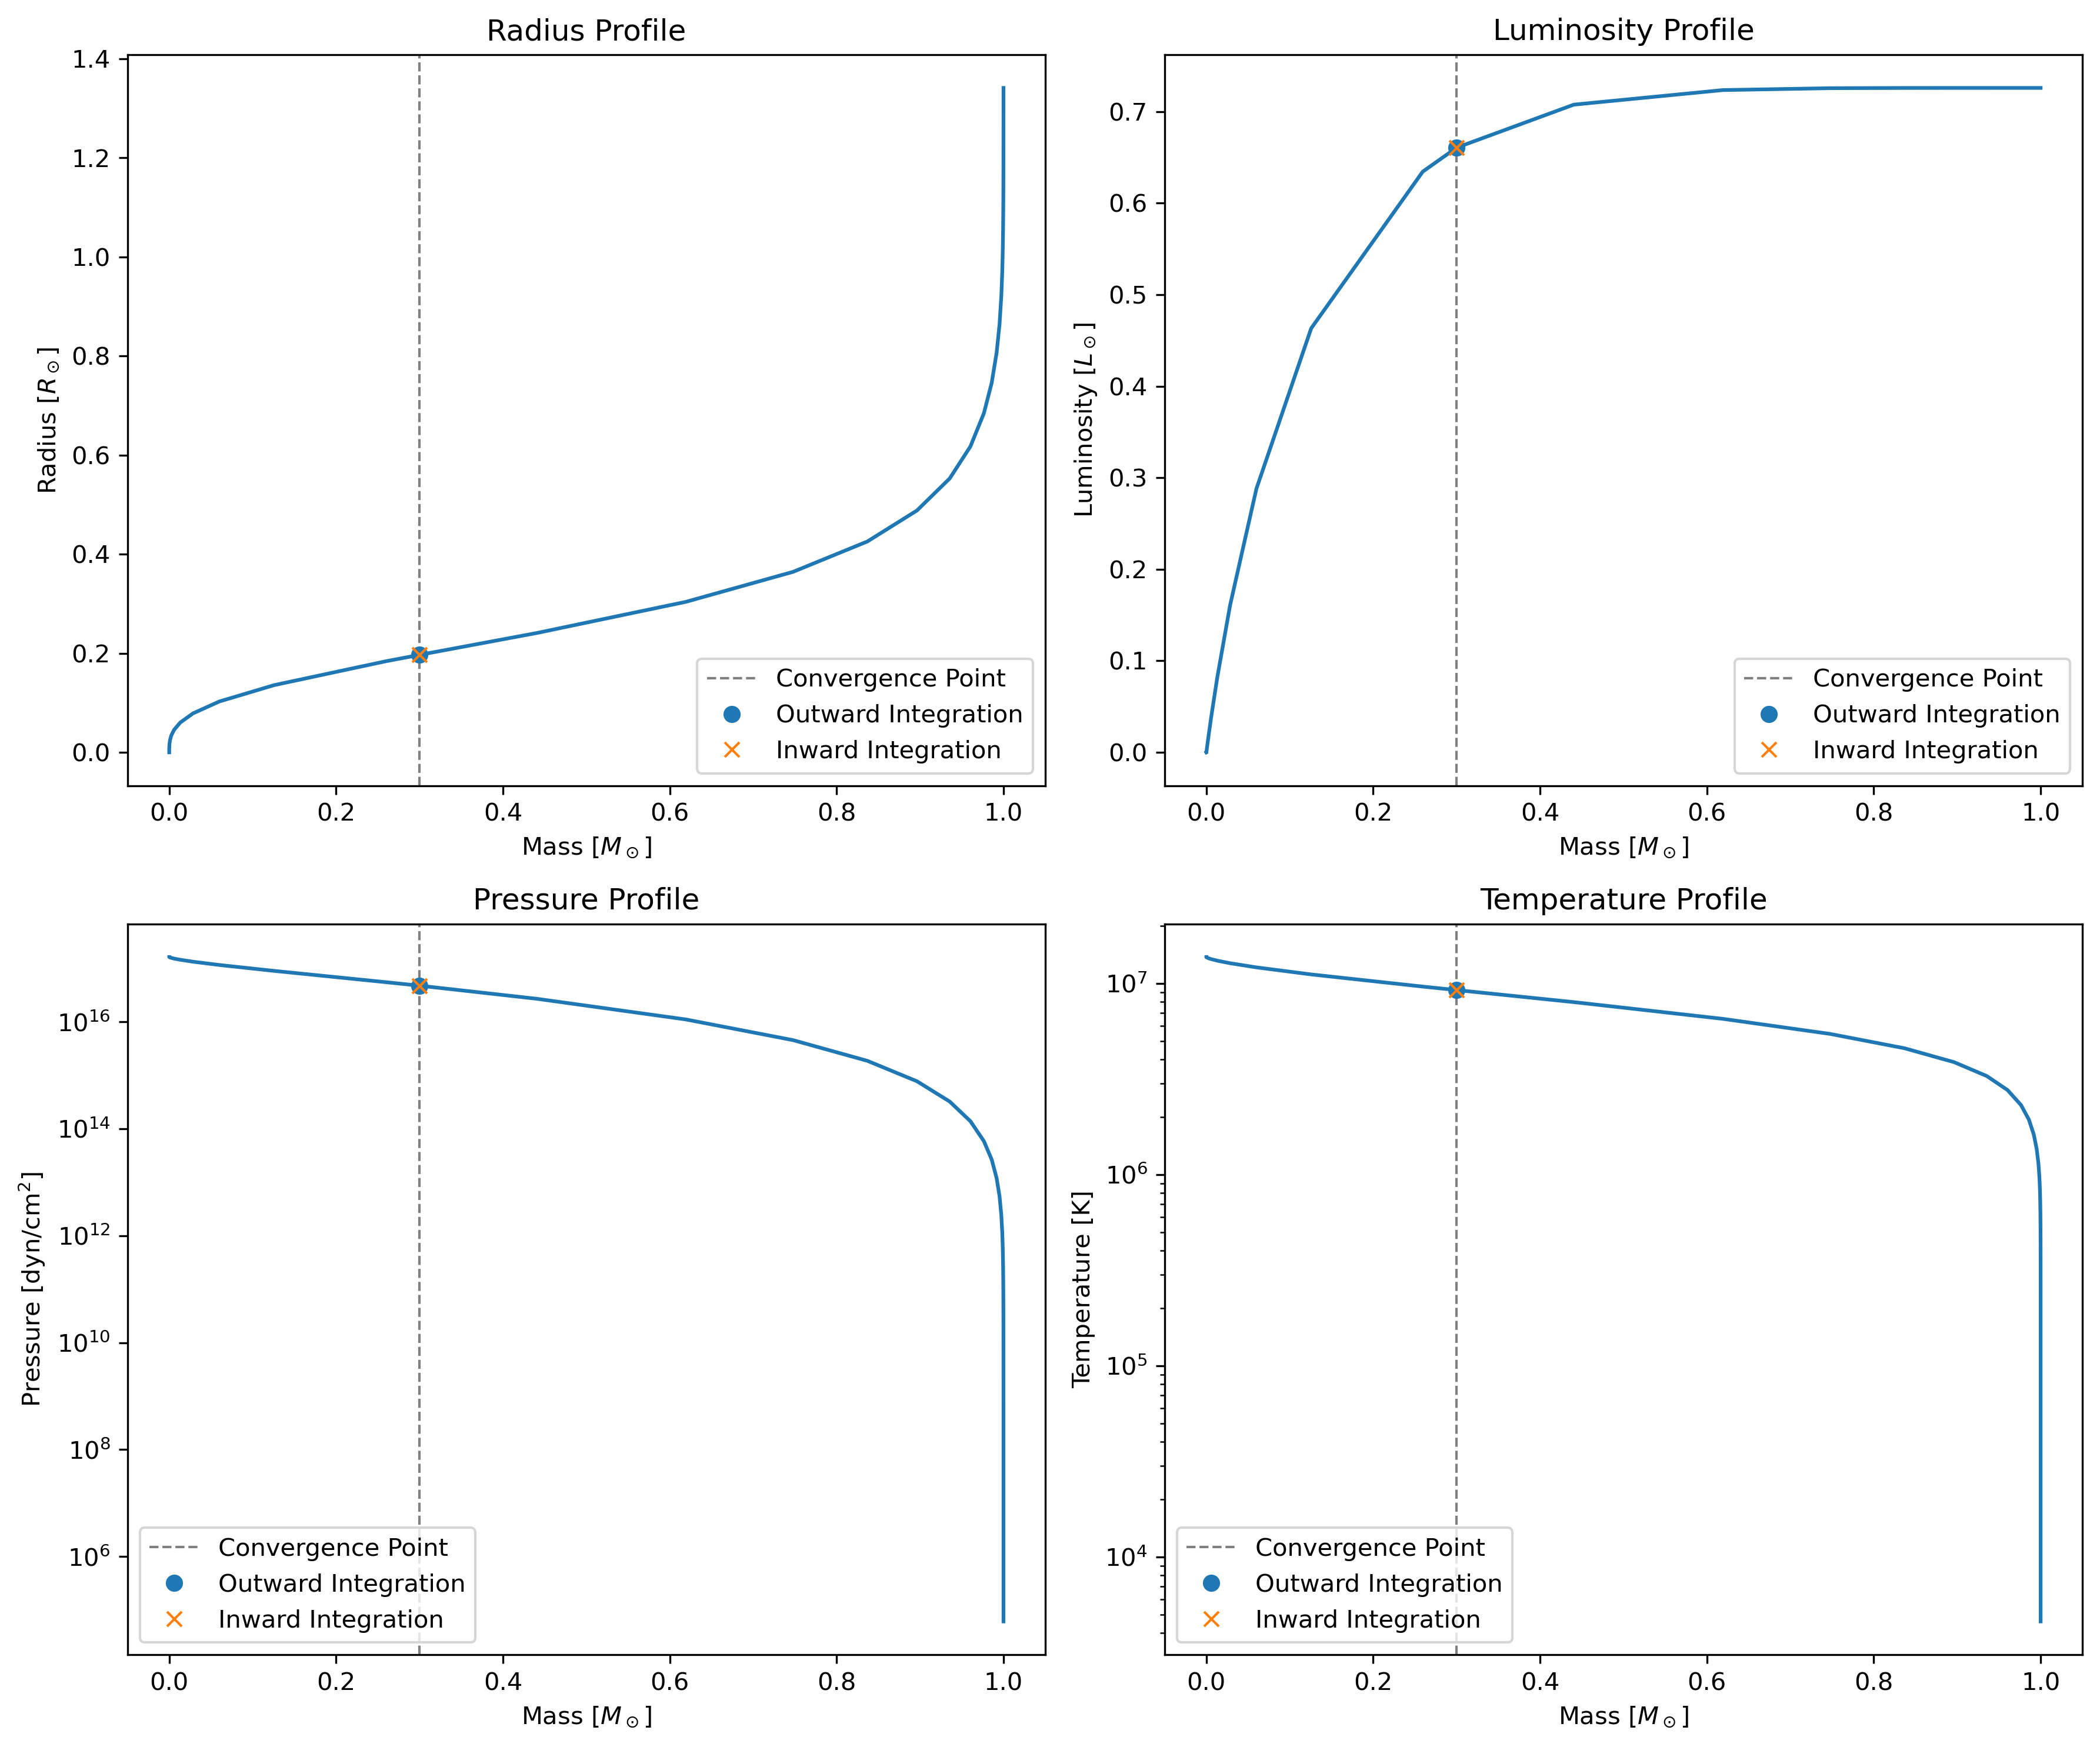


[mismatch at match point (normalized difference)]
  dr/r  = 3.22e-11
  dL/L  = 2.56e-11
  dP/P  = -1.28e-10
  dT/T  = -2.93e-11


In [22]:
plot_final_structure(solution)

## Compare results with MESA results
MESA scripts are located in mesa_model. Modify inlist_project to match the mass and metallicity of the simulated star. Results are saved in LOGS. Use profile 1, which corresponds to the earliest modeled phase.

In [24]:
def read_mesa_profile(filename):
    """
    Reads a MESA profile file and returns a dictionary of columns.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Look for the line that starts with 'zone' (this is where column names start)
    for i, line in enumerate(lines):
        if line.strip().startswith('zone'):
            header_line = i
            break

    headers = lines[header_line].strip().split()
    data = np.loadtxt(filename, skiprows=header_line + 2)  # skip headers and units

    return {key: data[:, i] for i, key in enumerate(headers)}

In [25]:
mesa_data = read_mesa_profile("mesa_model/LOGS/profile1.data")

In [26]:
mesa = read_mesa_profile("mesa_model/LOGS/profile1.data")
print(mesa.keys())

dict_keys(['zone', 'mass', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H', 'y_mass_fraction_He', 'z_mass_fraction_metals', 'pp', 'cno', 'tri_alpha'])


In [27]:
def compare_mesa(solution, mesa_profile_path="mesa_model/LOGS/profile1.data"):
    """
    Compare model to MESA model and plot residuals.

    Parameters:
        solution : OptimizeResult
            Converged result from shooting method
        mesa_profile_path : str
            Path to a specific MESA profile file
    """
    # My model
    R_guess, L_guess, P_c_guess, T_c_guess = solution.x
    m_match = 0.3 * M_sol
    m_core_start = 1e-10 * M_sol
    m_surface_start = M_sol

    y_inner_0 = load1(m_core_start, P_c_guess, T_c_guess)
    sol_outward = solve_ivp(derivs, [m_core_start, m_match], y_inner_0)
    y_outer_0 = load2(R_guess, L_guess)
    sol_inward = solve_ivp(derivs, [m_surface_start, m_match], y_outer_0)

    m_inward = sol_inward.t[::-1]
    y_inward = sol_inward.y[:, ::-1]

    m_custom = np.concatenate([sol_outward.t, m_inward])  # [g]
    r_custom = np.concatenate([sol_outward.y[0], y_inward[0]])  # [cm]
    P_custom = np.concatenate([sol_outward.y[2], y_inward[2]])
    T_custom = np.concatenate([sol_outward.y[3], y_inward[3]])

    # Compute surface gravity
    g_custom = G * m_custom / r_custom**2

    # MESA model
    mesa = read_mesa_profile(mesa_profile_path)

    m_mesa = np.array(mesa["mass"]) * M_sol      # [g]
    r_mesa = 10 ** np.array(mesa["logR"]) * R_sol  # [cm]
    T_mesa = 10 ** np.array(mesa["logT"])        # [K]
    P_mesa = 10 ** np.array(mesa["logP"])        # [dyn/cm²]
    g_mesa = G * m_mesa / r_mesa**2              # [cm/s²]

    # Interpolate my model onto MESA mass grid
    r_interp = np.interp(m_mesa, m_custom, r_custom / R_sol)
    P_interp = np.interp(m_mesa, m_custom / M_sol, P_custom)
    T_interp = np.interp(m_mesa, m_custom / M_sol, T_custom)
    g_interp = np.interp(m_mesa, m_custom, g_custom)

    # Residuals
    r_resid = (r_interp * R_sol - r_mesa) / r_mesa
    P_resid = (P_interp - P_mesa) / P_mesa
    T_resid = (T_interp - T_mesa) / T_mesa
    g_resid = (g_interp - g_mesa) / g_mesa

    # Plot: 2x4 grid
    fig, axs = plt.subplots(2, 4, figsize=(18, 6), dpi=300, height_ratios=[3, 1], sharex=True)

    # Top row: structure profiles
    axs[0, 0].plot(m_custom / M_sol, r_custom / R_sol, label="My Model")
    axs[0, 0].plot(m_mesa / M_sol, r_mesa / R_sol, label="MESA")
    axs[0, 0].set_ylabel("Radius [$R_\\odot$]")
    axs[0, 0].set_title("Radius")

    axs[0, 1].plot(m_custom / M_sol, P_custom, label="My Model")
    axs[0, 1].plot(m_mesa / M_sol, P_mesa, label="MESA")
    axs[0, 1].set_yscale("log")
    axs[0, 1].set_ylabel("Pressure [dyn/cm$^2$]")
    axs[0, 1].set_title("Pressure")

    axs[0, 2].plot(m_custom / M_sol, T_custom, label="My Model")
    axs[0, 2].plot(m_mesa / M_sol, T_mesa, label="MESA")
    axs[0, 2].set_yscale("log")
    axs[0, 2].set_ylabel("Temperature [K]")
    axs[0, 2].set_title("Temperature")

    axs[0, 3].plot(m_custom / M_sol, g_custom, label="My Model")
    axs[0, 3].plot(m_mesa / M_sol, g_mesa, label="MESA")
    axs[0, 3].set_yscale("log")
    axs[0, 3].set_ylabel("Surface Gravity [cm/s²]")
    axs[0, 3].set_title("Surface Gravity")

    # Bottom row: residuals
    axs[1, 0].plot(m_mesa / M_sol, r_resid, color='black', ls='--')
    axs[1, 0].set_xlabel("Mass [$M_\\odot$]")
    axs[1, 0].set_ylabel("Frac. Diff")

    axs[1, 1].plot(m_mesa / M_sol, P_resid, color='black', ls='--')
    axs[1, 1].set_xlabel("Mass [$M_\\odot$]")
    axs[1, 1].set_ylabel("Frac. Diff")

    axs[1, 2].plot(m_mesa / M_sol, T_resid, color='black', ls='--')
    axs[1, 2].set_xlabel("Mass [$M_\\odot$]")
    axs[1, 2].set_ylabel("Frac. Diff")

    axs[1, 3].plot(m_mesa / M_sol, g_resid, color='black', ls='--')
    axs[1, 3].set_xlabel("Mass [$M_\\odot$]")
    axs[1, 3].set_ylabel("Frac. Diff")

    for ax in axs.flat:
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

/var/folders/nz/df1z6w515yngdhnm_4p36qkc0005yb/T/ipykernel_71668/3318767522.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


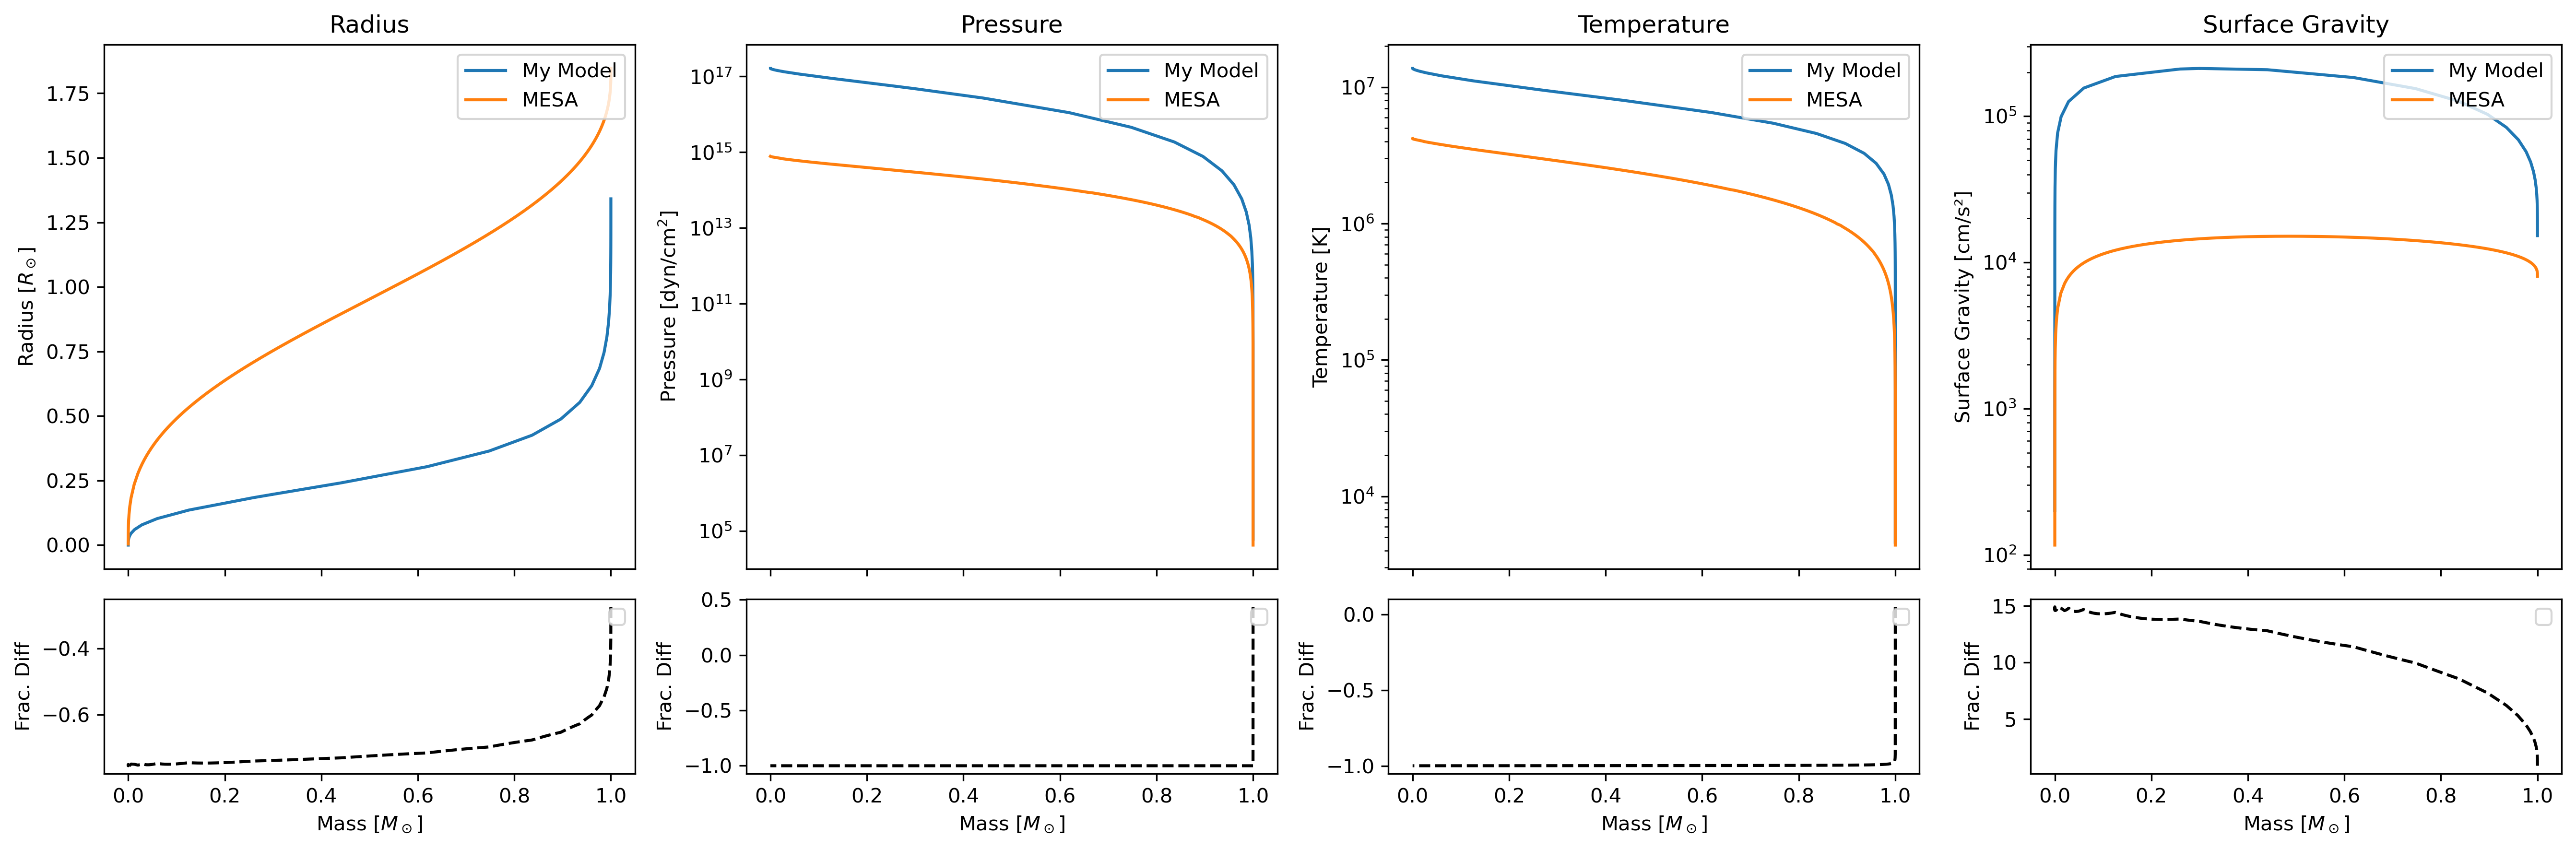

In [28]:
compare_mesa(solution)